# User Classification using Embeddings

**Date:** 4th December 2024

**Dataset:** German Web Tracking

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [2]:
import pickle
import numpy as np
import pandas as pd

from cybergpt.models.classification import ClassificationEvaluation, PCAReducer
from cybergpt.models.utils import feature_df_to_numpy

## Data

In order to generate the required processed data, please run the following:

**Embeddings**

```shell
python -m cybergpt.models.embed.websites \
    --data_csv path/to/raw/data.csv \
    --output_dir data/embeddings \
    --models openai openai-large minilm e5 tfidf \
    --sample_size 200
```

Note that sequences of domain visits are first mapped to strings which look like this:

`"Monday 14:15, Visits: google.com (10s) -> youtube.com (89s) -> google.com (32s) -> amazon.de (123s)"`

**Features**

```shell
python -m cybergpt.models.features \
    --data_csv path/to/raw/data.csv \
    --output_dir data/features
```

In [3]:
SEQUENCES_PICKLE = "../data/embeddings/preprocessed_dataset.pkl"
EMBEDDINGS_PICKLES = {
    "openai": "../data/embeddings/embeddings_openai.pkl",
    "openai-large": "../data/embeddings/embeddings_openai-large.pkl",
    "tfidf": "../data/embeddings/embeddings_tfidf.pkl",
    "e5": "../data/embeddings/embeddings_e5.pkl",
    "minilm": "../data/embeddings/embeddings_minilm.pkl",
}
FEATURES_PICKLE = "../data/features/features.pkl"

In [4]:
data = pickle.load(open(SEQUENCES_PICKLE, "rb"))
sequences = data["string_sequences"]
labels = data["labels"]

embeddings = {e: pickle.load(open(p, "rb")) for e, p in EMBEDDINGS_PICKLES.items()}

In [5]:
feature_data = pickle.load(open(FEATURES_PICKLE, "rb"))
all_labels = feature_data["labels"]
features = feature_data["features"]
np_features = feature_df_to_numpy(features)

In [6]:
# Align features with embeddings subset
users = pd.Series(labels).drop_duplicates().to_list()
feature_arrays = [
    np.array([f for f, l in zip(np_features, all_labels) if l == u]) for u in users
]
np_features = np.concatenate(feature_arrays)

In [7]:
print("Shapes:")
{"features": np_features.shape} | {k: v.shape for k, v in embeddings.items()}

Shapes:


{'features': (7806, 51),
 'openai': (7806, 1536),
 'openai-large': (7806, 3072),
 'tfidf': (7806, 11387),
 'e5': (7806, 384),
 'minilm': (7806, 384)}

In [8]:
print(f"Number of sequences: {len(labels)}")

Number of sequences: 7806


Remove users with fewer than `MIN_SUPPORT` sequences.

In [9]:
MIN_SUPPORT = 20

In [10]:
few_labels = pd.Series(labels).value_counts()
few_labels = list(few_labels[few_labels < MIN_SUPPORT].index)

In [11]:
np_features = np.array([f for f, l in zip(np_features, labels) if l not in few_labels])
embeddings = {
    k: np.array([e for e, l in zip(embs, labels) if l not in few_labels])
    for k, embs in embeddings.items()
}
labels = [l for l in labels if l not in few_labels]

In [12]:
print(f"Remaining number of users: {pd.Series(labels).nunique()}")
print(f"Remaining number of sequences: {len(labels)}")

Remaining number of users: 121
Remaining number of sequences: 7126


## Classification Results

- Baseline uses hand-crafted features based on the sequences. See `cybergpt.models.features` for details.
- Embeddings are projected down via PCA so they have the same number of dimensions as the number of features in the baseline.
- Multinomial logistic regression and random forest classifiers are applied to the (projected) feature matrices in order to predict the user_id.

In [13]:
results = {}

In [14]:
y = np.array(labels)
train_indices = None
cv_splits = None

print("Features Baseline")
print("-" * len("Features Baseline"))

X = np_features
evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results["baseline"] = evaluator.evaluate_models()

train_indices = evaluator.train_indices
cv_splits = evaluator.cv_splits

print("")

Features Baseline
-----------------

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.34642356241234223
macro avg: {'precision': 0.30078801835907654, 'recall': 0.284580111476388, 'f1-score': 0.2731764692112418, 'support': 1426.0}
weighted avg: {'precision': 0.332460280125103, 'recall': 0.34642356241234223, 'f1-score': 0.31990827531784954, 'support': 1426.0}

Cross-validation scores: 0.324 (+/- 0.013)

Evaluating rf...

Classification Report for rf:
accuracy: 0.33099579242636745
macro avg: {'precision': 0.25136673909624035, 'recall': 0.25468309363287056, 'f1-score': 0.24335859173665902, 'support': 1426.0}
weighted avg: {'precision': 0.3045113442244951, 'recall': 0.33099579242636745, 'f1-score': 0.305314584645922, 'support': 1426.0}

Cross-validation scores: 0.318 (+/- 0.011)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
PROJ_DIM = np_features.shape[1]
PROJ_DIM

51

Model: openai
-------------


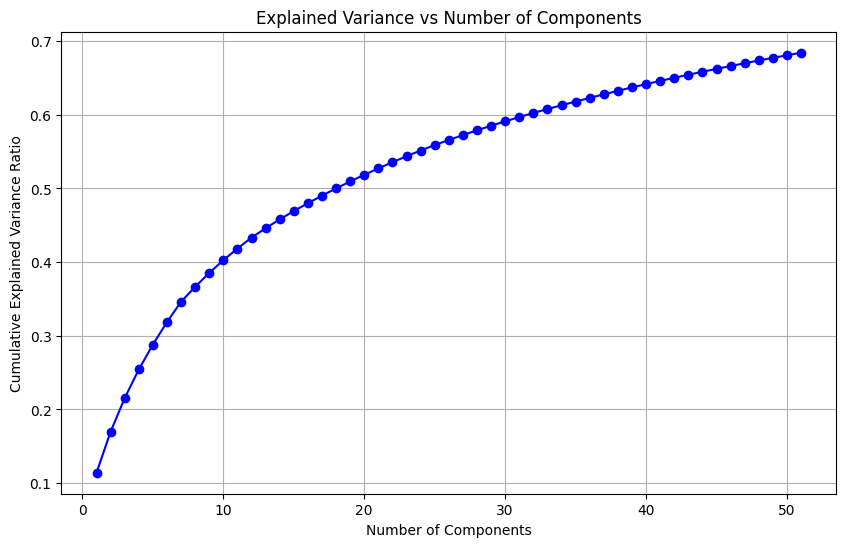

Original shape: (7126, 1536)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.684

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.7208976157082749
macro avg: {'precision': 0.6853772607312372, 'recall': 0.6600321568112106, 'f1-score': 0.6628807507553086, 'support': 1426.0}
weighted avg: {'precision': 0.7311564199589828, 'recall': 0.7208976157082749, 'f1-score': 0.718885969572287, 'support': 1426.0}

Cross-validation scores: 0.726 (+/- 0.026)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6802244039270687
macro avg: {'precision': 0.6576508658262624, 'recall': 0.5908085983861425, 'f1-score': 0.5965552113138919, 'support': 1426.0}
weighted avg: {'precision': 0.6869979170734841, 'recall': 0.6802244039270687, 'f1-score': 0.6630925390498998, 'support': 1426.0}

Cross-validation scores: 0.681 (+/- 0.020)

Model: openai-large
-------------------


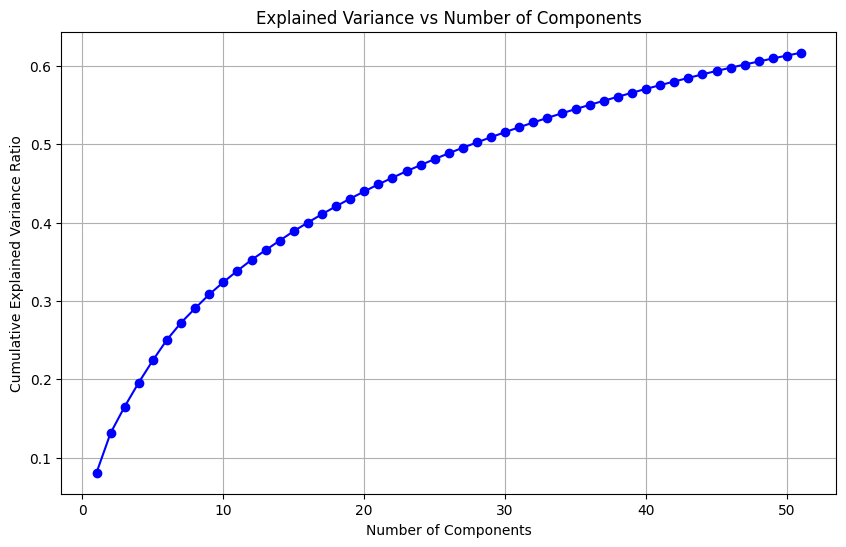

Original shape: (7126, 3072)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.617

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.7215988779803647
macro avg: {'precision': 0.6697967667903167, 'recall': 0.6496189741173104, 'f1-score': 0.6482646572902602, 'support': 1426.0}
weighted avg: {'precision': 0.7287505707846469, 'recall': 0.7215988779803647, 'f1-score': 0.7167416701990246, 'support': 1426.0}

Cross-validation scores: 0.729 (+/- 0.014)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.6507713884992987
macro avg: {'precision': 0.6044404460922246, 'recall': 0.5534777996522985, 'f1-score': 0.5551034072128167, 'support': 1426.0}
weighted avg: {'precision': 0.6524984328005511, 'recall': 0.6507713884992987, 'f1-score': 0.6330827707934711, 'support': 1426.0}

Cross-validation scores: 0.667 (+/- 0.020)

Model: tfidf
------------


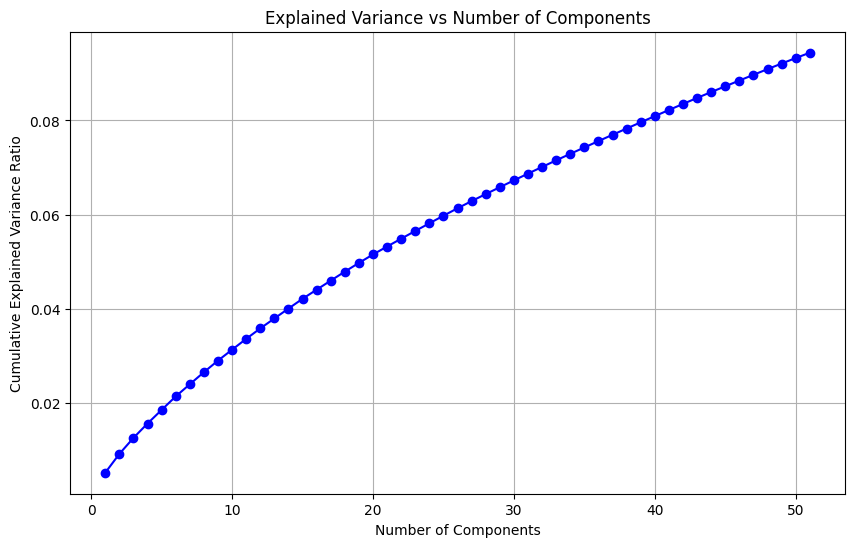

Original shape: (7126, 11387)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.094

Evaluating logistic...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for logistic:
accuracy: 0.22861150070126227
macro avg: {'precision': 0.19863483975133872, 'recall': 0.16318188458055782, 'f1-score': 0.14883676293145293, 'support': 1426.0}
weighted avg: {'precision': 0.2099667888021269, 'recall': 0.22861150070126227, 'f1-score': 0.1758025484013587, 'support': 1426.0}

Cross-validation scores: 0.228 (+/- 0.009)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.39691444600280507
macro avg: {'precision': 0.3684063003779217, 'recall': 0.33108289649222594, 'f1-score': 0.31900167851004907, 'support': 1426.0}
weighted avg: {'precision': 0.38122107516518766, 'recall': 0.39691444600280507, 'f1-score': 0.36046158427174124, 'support': 1426.0}

Cross-validation scores: 0.407 (+/- 0.023)

Model: e5
---------


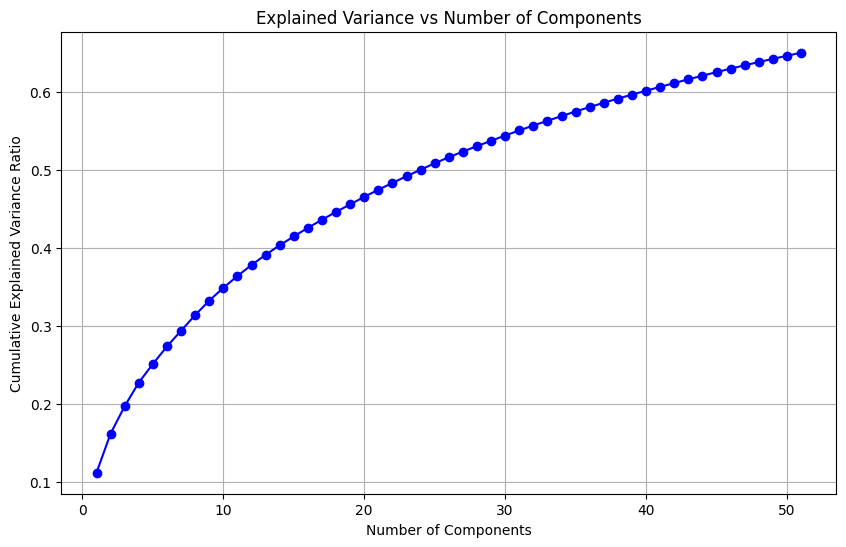

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.650

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6402524544179523
macro avg: {'precision': 0.5713167362362672, 'recall': 0.5564423816696711, 'f1-score': 0.5518979293650896, 'support': 1426.0}
weighted avg: {'precision': 0.6357806865022217, 'recall': 0.6402524544179523, 'f1-score': 0.6291407575096072, 'support': 1426.0}

Cross-validation scores: 0.634 (+/- 0.025)

Evaluating rf...


/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for rf:
accuracy: 0.5680224403927069
macro avg: {'precision': 0.4812133571231294, 'recall': 0.4550947122525113, 'f1-score': 0.44579184569991753, 'support': 1426.0}
weighted avg: {'precision': 0.5427637878999835, 'recall': 0.5680224403927069, 'f1-score': 0.5352514821065728, 'support': 1426.0}

Cross-validation scores: 0.565 (+/- 0.021)

Model: minilm
-------------


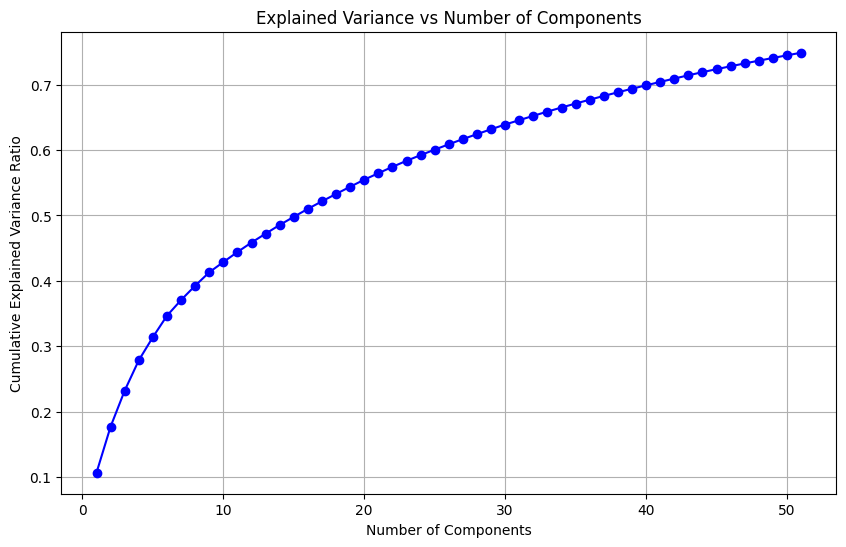

Original shape: (7126, 384)
Reduced shape: (7126, 51)
Total explained variance ratio: 0.749

Evaluating logistic...

Classification Report for logistic:
accuracy: 0.6458625525946704
macro avg: {'precision': 0.5999228219659835, 'recall': 0.5779131916059875, 'f1-score': 0.5753826961430321, 'support': 1426.0}
weighted avg: {'precision': 0.6541011997982409, 'recall': 0.6458625525946704, 'f1-score': 0.6396773505268821, 'support': 1426.0}

Cross-validation scores: 0.644 (+/- 0.022)

Evaluating rf...

Classification Report for rf:
accuracy: 0.5925666199158486
macro avg: {'precision': 0.5606733174554103, 'recall': 0.4938186984334453, 'f1-score': 0.4933635100770753, 'support': 1426.0}
weighted avg: {'precision': 0.5874994997698599, 'recall': 0.5925666199158486, 'f1-score': 0.564095505843218, 'support': 1426.0}

Cross-validation scores: 0.608 (+/- 0.007)



/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcos/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
y = np.array(labels)
for model, embs in embeddings.items():
    print(f"Model: {model}")
    print("-" * len(f"Model: {model}"))

    X = embs
    X_train = X[train_indices, :]
    reducer = PCAReducer()
    reducer.fit(X_train, PROJ_DIM)
    _ = reducer.analyze_explained_variance()

    X_reduced = reducer.reduce_dimensions(X)

    evaluator = ClassificationEvaluation(X_reduced, y, train_indices, cv_splits)
    evaluator.prepare_data()
    results[model] = evaluator.evaluate_models()

    train_indices = evaluator.train_indices
    cv_splits = evaluator.cv_splits

    print("")

In [17]:
output = {
    "results": results,
    "labels": labels,
}
pickle.dump(output, open("../data/embeddings/results.pkl", "wb"))

### Results Summary

In [18]:
def summary(model):
    return (
        pd.DataFrame(
            {
                k: {
                    f"mean_{m}": v
                    for m, v in results[k][model]["classification_report"][
                        "macro avg"
                    ].items()
                }
                | {
                    "accuracy": results[k][model]["classification_report"]["accuracy"],
                    "mean_cv_score": np.mean(results[k][model]["cv_scores"]),
                }
                for k in results
            }
        )
        .T.sort_values("mean_f1-score", ascending=False)
        .round(2)
        .drop("mean_support", axis=1)
    )

In [19]:
summary("logistic")

,mean_precision,mean_recall,mean_f1-score,accuracy,mean_cv_score
openai,0.69,0.66,0.66,0.72,0.73
openai-large,0.67,0.65,0.65,0.72,0.73
minilm,0.60,0.58,0.58,0.65,0.64
e5,0.57,0.56,0.55,0.64,0.63
baseline,0.30,0.28,0.27,0.35,0.32
tfidf,0.20,0.16,0.15,0.23,0.23


In [20]:
summary("rf")

,mean_precision,mean_recall,mean_f1-score,accuracy,mean_cv_score
openai,0.66,0.59,0.60,0.68,0.68
openai-large,0.60,0.55,0.56,0.65,0.67
minilm,0.56,0.49,0.49,0.59,0.61
e5,0.48,0.46,0.45,0.57,0.56
tfidf,0.37,0.33,0.32,0.40,0.41
baseline,0.25,0.25,0.24,0.33,0.32


### Without PCA Reduction

Look at difference in performance for `openai` embeddings when we don't apply PCA.

In [21]:
model = "openai"

y = np.array(labels)
X = embeddings[model]
X_train = X[train_indices, :]

evaluator = ClassificationEvaluation(X, y, train_indices, cv_splits)
evaluator.prepare_data()
results_full_dim = evaluator.evaluate_models(model_names=["logistic"])


Evaluating logistic...

Classification Report for logistic:
accuracy: 0.7966339410939691
macro avg: {'precision': 0.7885482609682628, 'recall': 0.7546372096908915, 'f1-score': 0.7586056291602857, 'support': 1426.0}
weighted avg: {'precision': 0.8156052098400471, 'recall': 0.7966339410939691, 'f1-score': 0.7972069704657614, 'support': 1426.0}

Cross-validation scores: 0.803 (+/- 0.009)


In [22]:
pd.DataFrame(
    {
        k: {f"mean_{m}": v for m, v in r["classification_report"]["macro avg"].items()}
        | {
            "accuracy": r["classification_report"]["accuracy"],
            "mean_cv_score": np.mean(r["cv_scores"]),
        }
        for k, r in [
            ("with pca", results["openai"]["logistic"]),
            ("without pca", results_full_dim["logistic"]),
        ]
    }
).T.sort_values("mean_f1-score", ascending=False).round(2).drop("mean_support", axis=1)

,mean_precision,mean_recall,mean_f1-score,accuracy,mean_cv_score
without pca,0.79,0.75,0.76,0.80,0.80
with pca,0.69,0.66,0.66,0.72,0.73
